In [ ]:
import torch
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


In [ ]:
train = pd.read_csv('/content/drive/My Drive/home_credit/application_train.csv')
test = pd.read_csv('/content/drive/My Drive/home_credit/application_test.csv')
previous_application = pd.read_csv('/content/drive/My Drive/home_credit/previous_application.csv')

In [ ]:
train = train[train['CODE_GENDER'] != 'XNA']

In [ ]:
bureau = pd.read_csv('/content/drive/My Drive/home_credit/bureau.csv')
bureau_balance = pd.read_csv('/content/drive/My Drive/home_credit/bureau_balance.csv')
pos_cash_balance = pd.read_csv('/content/drive/My Drive/home_credit/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('/content/drive/My Drive/home_credit/credit_card_balance.csv')
installments_payments = pd.read_csv('/content/drive/My Drive/home_credit/installments_payments.csv')


In [ ]:
concat_application = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
app_categorical_columns = []
for c in concat_application.columns:
    if concat_application[c].dtype == object:
        print(c)
        app_categorical_columns.append(c)
        
for col in app_categorical_columns:
    le = LabelEncoder()
    le.fit(concat_application[col].values.reshape(-1, 1).astype('str'))
    concat_application[col] = le.transform(concat_application[col].values.reshape(-1, 1).astype('str'))


NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE


In [ ]:
def one_hot_encoder(df, column=None, nan_as_category=False):
    original_columns = list(df.columns)
    
    categorical_columns = []
    if not column:
        for c in df.columns:
            if df[c].dtype == object:
                print(c)
                categorical_columns.append(c)
        
        df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
            
    else:
        df = pd.get_dummies(df, columns=[column], dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    
    return df, categorical_columns


def aggregate(df, group_cols, agg_method):
    return df.groupby(group_cols).agg(agg_method).reset_index()





In [ ]:
# 歷史貸款申請紀錄

In [ ]:
previous_application, categorical_columns  = one_hot_encoder(previous_application)

previous_application['credit_application_diff'] = previous_application['AMT_APPLICATION'] - previous_application['AMT_CREDIT']
previous_application['application_ratio'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
previous_application['application_credit_goods_ratio'] = previous_application['AMT_GOODS_PRICE'] / previous_application['AMT_CREDIT']
previous_application['application_credit_annuity_ratio'] = previous_application['AMT_CREDIT'] / previous_application['AMT_ANNUITY']

# interest_rate = principal×interest rate×time = total_payment / AMT_CREDIT
previous_application['total_payment'] = previous_application['AMT_ANNUITY'] * previous_application['CNT_PAYMENT']
previous_application['interest_rate'] = previous_application['total_payment'] / previous_application['AMT_CREDIT']
previous_application['SK_ID_CURR_COUNT'] = previous_application.groupby(['SK_ID_CURR'])['SK_ID_PREV'].transform('count')

previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

previous_application['DAYS_DIFF'] = -previous_application['DAYS_FIRST_DUE'] - previous_application['DAYS_LAST_DUE']
previous_application['DAYS_FIRST_DRAWING_DIFF'] = -previous_application['DAYS_FIRST_DUE'] - previous_application['DAYS_FIRST_DRAWING']

previous_application['DAYS_FIRST_DRAWING'] = np.abs(previous_application['DAYS_FIRST_DRAWING'] / 365)
previous_application['DAYS_FIRST_DUE'] = np.abs(previous_application['DAYS_FIRST_DUE'] / 365)
previous_application['DAYS_LAST_DUE_1ST_VERSION'] = np.abs(previous_application['DAYS_LAST_DUE_1ST_VERSION'] / 365)
previous_application['DAYS_LAST_DUE'] = np.abs(previous_application['DAYS_LAST_DUE'] / 365)
previous_application['DAYS_TERMINATION'] = np.abs(previous_application['DAYS_TERMINATION'] / 365)
previous_application['DAYS_DECISION'] = np.abs(previous_application['DAYS_DECISION'] / 365)
previous_application['DAYS_LAST_DUE_DIFF'] = previous_application['DAYS_LAST_DUE_1ST_VERSION'] - previous_application['DAYS_LAST_DUE']

contract_cols = [
    'NAME_CONTRACT_STATUS_Approved',
    'NAME_CONTRACT_STATUS_Canceled',
    'NAME_CONTRACT_STATUS_Refused',
#     'NAME_CONTRACT_STATUS_Unused offer',
    'NAME_CONTRACT_TYPE_Consumer loans', 
    'NAME_CONTRACT_TYPE_Revolving loans'
]

agg_columns = {
    'AMT_ANNUITY': ['mean', 'max', 'min'],
    'AMT_APPLICATION': ['mean', 'max', 'min'],
    'AMT_ANNUITY': ['mean', 'max', 'min'],
    'AMT_CREDIT': ['mean', 'max', 'min'],
    'AMT_DOWN_PAYMENT': ['mean', 'max', 'min'],
    'AMT_GOODS_PRICE': ['mean', 'max', 'min'],
    'CNT_PAYMENT': ['mean', 'max', 'min'],
    'HOUR_APPR_PROCESS_START': ['mean', 'max', 'min'],
    'DAYS_DECISION': ['mean', 'max', 'min'],
    'DAYS_DIFF': ['mean', 'max', 'min'],
    'DAYS_FIRST_DRAWING': ['mean', 'max', 'min'],
    'DAYS_FIRST_DUE': ['mean', 'max', 'min'],
    'DAYS_LAST_DUE_1ST_VERSION': ['mean', 'max', 'min'],
    'DAYS_LAST_DUE': ['mean', 'max', 'min'],
    'DAYS_LAST_DUE_DIFF': ['mean', 'max', 'min'],
    'credit_application_diff': ['mean', 'max', 'min'],
    'application_ratio': ['mean', 'max', 'min'],
    'application_credit_goods_ratio': ['mean', 'max', 'min'],
    'application_credit_annuity_ratio': ['mean', 'max', 'min'],
    'total_payment': ['mean', 'max', 'min'],
    'interest_rate': ['mean', 'max', 'min']
}
  
merge_col = ['SK_ID_CURR', 'SK_ID_CURR_COUNT']
for col in contract_cols:
    print(col, sep=', ')
    df = previous_application[previous_application[col] == 1]
    df = aggregate(previous_application, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
    df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{col}_{c[0]}_{c[1]}' for c in df.columns.tolist()]
    merge_col.extend(list(df.columns[1:]))
    df.reset_index(drop=True)
    previous_application = pd.merge(left=previous_application, right=df, on='SK_ID_CURR', how='left')


previous_application = previous_application.drop_duplicates('SK_ID_CURR').reset_index(drop=True)
concat_application = pd.merge(left=concat_application, right=previous_application[merge_col], on='SK_ID_CURR', how='left')
concat_application.shape

NAME_CONTRACT_TYPE
WEEKDAY_APPR_PROCESS_START
FLAG_LAST_APPL_PER_CONTRACT
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
NAME_PAYMENT_TYPE
CODE_REJECT_REASON
NAME_TYPE_SUITE
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
NAME_PRODUCT_TYPE
CHANNEL_TYPE
NAME_SELLER_INDUSTRY
NAME_YIELD_GROUP
PRODUCT_COMBINATION
NAME_CONTRACT_STATUS_Approved
NAME_CONTRACT_STATUS_Canceled
NAME_CONTRACT_STATUS_Refused
NAME_CONTRACT_TYPE_Consumer loans
NAME_CONTRACT_TYPE_Revolving loans


(356251, 423)

In [ ]:
# 分期付款紀錄資料
installments_payments['ins_payment_ratio'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
installments_payments['ins_payment_diff'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

# 逾期未繳款
installments_payments['day_past_due'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['delay_pay'] = installments_payments['day_past_due'].apply(lambda x: 1 if x > 0 else 0)

installments_payments['early_pay_7'] = installments_payments['day_past_due'].apply(lambda x: 1 if x <= -7 and x < 0 else 0)
installments_payments['early_pay_14'] = installments_payments['day_past_due'].apply(lambda x: 1 if x <= -14 and x < 8 else 0)
installments_payments['early_pay_30'] = installments_payments['day_past_due'].apply(lambda x: 1 if x <= -30 and x < 15 else 0)
installments_payments['early_pay_60'] = installments_payments['day_past_due'].apply(lambda x: 1 if x <= -60 and x < 31 else 0)

installments_payments['day_past_due_7'] = installments_payments['day_past_due'].apply(lambda x: 1 if x >= 7 else 0)
installments_payments['day_past_due_14'] = installments_payments['day_past_due'].apply(lambda x: 1 if x >= 14 else 0)
installments_payments['day_past_due_30'] = installments_payments['day_past_due'].apply(lambda x: 1 if x >= 30 else 0)
installments_payments['day_past_due_60'] = installments_payments['day_past_due'].apply(lambda x: 1 if x >= 60 else 0)




In [ ]:
# 首期的分期付款逾期相關特徵
first_installment_payment = installments_payments.query("NUM_INSTALMENT_NUMBER == 1")
first_installment_payment['NUM_INSTALMENT_NUMBER_1_has_DPD'] = first_installment_payment['day_past_due'].apply(lambda x : 1 if x > 0 else 0 )
first_installment_payment['NUM_INSTALMENT_NUMBER_1_DPD'] = first_installment_payment['day_past_due'].apply(lambda x : x if x > 0 else 0 )

first_installment_payment['NUM_INSTALMENT_NUMBER_1_has_DPD_sum'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_has_DPD'].transform('sum')
first_installment_payment['NUM_INSTALMENT_NUMBER_1_has_DPD_mean'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_has_DPD'].transform('mean')

first_installment_payment['NUM_INSTALMENT_NUMBER_1_DPD_mean'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_DPD'].transform('mean')
first_installment_payment['NUM_INSTALMENT_NUMBER_1_DPD_min'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_DPD'].transform('min')
first_installment_payment['NUM_INSTALMENT_NUMBER_1_DPD_max'] = first_installment_payment.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_NUMBER_1_DPD'].transform('max')

merge_col = [
    'SK_ID_CURR',
    'NUM_INSTALMENT_NUMBER_1_has_DPD', 'NUM_INSTALMENT_NUMBER_1_DPD',
    'NUM_INSTALMENT_NUMBER_1_has_DPD_sum', 'NUM_INSTALMENT_NUMBER_1_has_DPD_mean',
    'NUM_INSTALMENT_NUMBER_1_DPD_mean', 'NUM_INSTALMENT_NUMBER_1_DPD_min', 'NUM_INSTALMENT_NUMBER_1_DPD_max'
]
first_installment_payment = first_installment_payment.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=first_installment_payment[merge_col], on='SK_ID_CURR', how='left')





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
agg_columns = {
    'AMT_INSTALMENT': ['mean', 'max', 'min'],
    'AMT_PAYMENT': ['mean', 'max', 'min'],
    'NUM_INSTALMENT_NUMBER': ['mean', 'max', 'min'],
    'day_past_due': ['mean', 'max', 'min'],
    'ins_payment_ratio': ['mean', 'max', 'min'],
    'ins_payment_diff': ['mean', 'max', 'min'],
    'early_pay_7': ['mean'],
    'early_pay_14': ['mean'],
    'early_pay_30': ['mean'],
    'early_pay_60': ['mean'],
    'day_past_due_7': ['mean'],
    'day_past_due_14': ['mean'],
    'day_past_due_30': ['mean'],
    'day_past_due_60': ['mean'],
    'delay_pay': ['mean'],
}

merge_col = ['SK_ID_CURR']
df = aggregate(installments_payments, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
installments_payments = pd.merge(left=installments_payments, right=df, on='SK_ID_CURR', how='left')
    
installments_payments = installments_payments.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=installments_payments[merge_col], on='SK_ID_CURR', how='left')

concat_application.shape

(356251, 457)

In [ ]:
bureau = pd.read_csv('/content/drive/My Drive/home_credit/bureau.csv')
bureau_balance = pd.read_csv('/content/drive/My Drive/home_credit/bureau_balance.csv')

In [ ]:
# 其他來源的過去信貸資料
bureau, categorical_columns  = one_hot_encoder(bureau)
bureau_balance, bureau_balance_categorical_columns = one_hot_encoder(bureau_balance)

# Credit duration and credit/account end date difference
bureau['credit_duration'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['actually_end_date'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']

# Credit to debt ratio and difference
bureau['debt_percentage'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['debt_credit_diff'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['credit_annuity_ratio'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']




CREDIT_ACTIVE
CREDIT_CURRENCY
CREDIT_TYPE
STATUS


In [ ]:

agg_columns = {
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_2': ['mean'],
    'STATUS_3': ['mean'],
    'STATUS_4': ['mean'],
    'STATUS_5': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'MONTHS_BALANCE': ['mean', 'count', 'min', 'max']
}

# bureau_balance.groupby('SK_ID_BUREAU')[bureau_balance_categorical_columns].mean().reset_index()
df = bureau_balance.groupby('SK_ID_BUREAU').agg(agg_columns).reset_index()
df.columns = [c[0] if c[0] == 'SK_ID_BUREAU' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
df.reset_index(drop=True)
bureau = pd.merge(left=bureau, right=df, on='SK_ID_BUREAU', how='left')


# df = bureau_balance.groupby('MONTHS_BALANCE').agg(agg_columns).reset_index()
# df.columns = [c[0] if c[0] == 'MONTHS_BALANCE' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
# df.reset_index(drop=True)
# bureau = pd.merge(left=bureau, right=df, on='MONTHS_BALANCE', how='left')

In [ ]:
agg_columns = {
    'STATUS_0_mean': ['mean', 'max', 'min'],
    'STATUS_1_mean': ['mean', 'max', 'min'],
    'STATUS_2_mean': ['mean', 'max', 'min'],
    'STATUS_3_mean': ['mean', 'max', 'min'],
    'STATUS_4_mean': ['mean', 'max', 'min'],
    'STATUS_5_mean': ['mean', 'max', 'min'],
    'STATUS_C_mean': ['mean', 'max', 'min'],
    'STATUS_X_mean': ['mean', 'max', 'min']
}

merge_col = ['SK_ID_CURR']
df = aggregate(bureau, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
bureau = pd.merge(left=bureau, right=df, on='SK_ID_CURR', how='left').drop(columns=list(agg_columns.keys()))




agg_columns = {
    'AMT_CREDIT_MAX_OVERDUE': ['mean'], 
    'AMT_CREDIT_SUM_OVERDUE': ['mean'], 
    'AMT_CREDIT_SUM': ['mean'],
    'AMT_CREDIT_SUM_DEBT': ['mean'], 
    'DAYS_CREDIT_UPDATE': ['mean'],
    'credit_duration': ['mean'],
    'actually_end_date': ['mean'],
    'debt_percentage': ['mean', 'min', 'max'],
    'debt_credit_diff': ['mean', 'min', 'max'],
    'credit_annuity_ratio': ['mean', 'min', 'max'],
    
}


df = aggregate(bureau, group_cols=['MONTHS_BALANCE_count'], agg_method=agg_columns)
df.columns = [c[0] if c[0] == 'MONTHS_BALANCE_count' else f'MONTHS_BALANCE_{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
bureau = pd.merge(left=bureau, right=df, on='MONTHS_BALANCE_count', how='left')


for col in categorical_columns:
    print(col)
    df = bureau[bureau[col] == 1]
    df = aggregate(bureau, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
    df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{col}_{c[0]}_{c[1]}' for c in df.columns.tolist()]
    merge_col.extend(list(df.columns[1:]))
    df.reset_index(drop=True)
    bureau = pd.merge(left=bureau, right=df, on='SK_ID_CURR', how='left')


bureau = bureau.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=bureau[merge_col], on='SK_ID_CURR', how='left')
concat_application.shape






CREDIT_ACTIVE_Active
CREDIT_ACTIVE_Bad debt
CREDIT_ACTIVE_Closed
CREDIT_ACTIVE_Sold
CREDIT_CURRENCY_currency 1
CREDIT_CURRENCY_currency 2
CREDIT_CURRENCY_currency 3
CREDIT_CURRENCY_currency 4
CREDIT_TYPE_Another type of loan
CREDIT_TYPE_Car loan
CREDIT_TYPE_Cash loan (non-earmarked)
CREDIT_TYPE_Consumer credit
CREDIT_TYPE_Credit card
CREDIT_TYPE_Interbank credit
CREDIT_TYPE_Loan for business development
CREDIT_TYPE_Loan for purchase of shares (margin lending)
CREDIT_TYPE_Loan for the purchase of equipment
CREDIT_TYPE_Loan for working capital replenishment
CREDIT_TYPE_Microloan
CREDIT_TYPE_Mobile operator loan
CREDIT_TYPE_Mortgage
CREDIT_TYPE_Real estate loan
CREDIT_TYPE_Unknown type of loan


(356251, 865)

In [ ]:
pos_cash_balance['pos_prev_SK_ID_CURR_COUNT'] = pos_cash_balance.groupby(['SK_ID_CURR'])['SK_ID_PREV'].transform('count')
pos_cash_balance['CNT_INSTALMENT_FUTURE_max'] = pos_cash_balance.groupby(['SK_ID_PREV'])['CNT_INSTALMENT_FUTURE'].transform('max')
pos_cash_balance['CNT_INSTALMENT_max'] = pos_cash_balance.groupby(['SK_ID_PREV'])['CNT_INSTALMENT'].transform('max')
pos_cash_balance['remaining_installment'] = pos_cash_balance['CNT_INSTALMENT_max']  - pos_cash_balance['CNT_INSTALMENT_FUTURE_max']
pos_cash_balance['has_remaining_installment'] = pos_cash_balance['remaining_installment'].apply(lambda x: 1 if x > 0 else 0)
pos_cash_balance['remaining_installment_sum'] = pos_cash_balance.groupby(['SK_ID_PREV'])['has_remaining_installment'].transform('sum')
pos_cash_balance['pos_installment_ratio'] =  pos_cash_balance['remaining_installment_sum'] / pos_cash_balance['pos_prev_SK_ID_CURR_COUNT']

pos_cash_balance, categorical_columns  = one_hot_encoder(pos_cash_balance)
pos_cash_balance['delay_payment'] = pos_cash_balance['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

agg_columns = {key: ['mean'] for key in categorical_columns}

agg_columns['SK_DPD'] = ['mean', 'min', 'max', 'sum']
agg_columns['SK_DPD_DEF'] = ['mean', 'min', 'max', 'sum']
agg_columns['delay_payment'] = ['mean', 'min', 'max', 'sum']
agg_columns['MONTHS_BALANCE'] =['min', 'max', 'count']
agg_columns['has_remaining_installment'] = ['mean', 'min', 'max', 'sum']
agg_columns['remaining_installment_sum'] = ['mean', 'min', 'max', 'sum']
agg_columns['pos_installment_ratio'] = ['mean', 'min', 'max']


merge_col = ['SK_ID_CURR', 'pos_prev_SK_ID_CURR_COUNT']

df = aggregate(pos_cash_balance, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
df.reset_index(drop=True)
df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
pos_cash_balance = pd.merge(left=pos_cash_balance, right=df, on='SK_ID_CURR', how='left').drop(columns=list(agg_columns.keys()))

merge_col = [
    'SK_ID_CURR',
    'pos_prev_SK_ID_CURR_COUNT',
    'remaining_installment',
    'NAME_CONTRACT_STATUS_Active_mean',
    'NAME_CONTRACT_STATUS_Amortized debt_mean',
    'NAME_CONTRACT_STATUS_Approved_mean',
    'NAME_CONTRACT_STATUS_Canceled_mean',
    'NAME_CONTRACT_STATUS_Completed_mean',
    'NAME_CONTRACT_STATUS_Demand_mean',
    'NAME_CONTRACT_STATUS_Returned to the store_mean',
    'NAME_CONTRACT_STATUS_Signed_mean', 'NAME_CONTRACT_STATUS_XNA_mean',
    'SK_DPD_mean', 'SK_DPD_min', 'SK_DPD_max', 'SK_DPD_sum',
    'SK_DPD_DEF_mean', 'SK_DPD_DEF_min', 'SK_DPD_DEF_max', 'SK_DPD_DEF_sum',
    'delay_payment_mean', 'delay_payment_min', 'delay_payment_max',
    'delay_payment_sum', 'MONTHS_BALANCE_min', 'MONTHS_BALANCE_max',
    'MONTHS_BALANCE_count', 'has_remaining_installment_mean',
    'has_remaining_installment_min', 'has_remaining_installment_max',
    'has_remaining_installment_sum', 'remaining_installment_sum_mean',
    'remaining_installment_sum_min', 'remaining_installment_sum_max',
    'remaining_installment_sum_sum', 'pos_installment_ratio_mean',
    'pos_installment_ratio_min', 'pos_installment_ratio_max'
]
pos_cash_balance = pos_cash_balance.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=pos_cash_balance[merge_col], on='SK_ID_CURR', how='left')
concat_application.shape

NAME_CONTRACT_STATUS


(356251, 902)

In [ ]:
credit_card_balance, categorical_columns  = one_hot_encoder(credit_card_balance)
agg_columns = {key: ['mean'] for key in categorical_columns}
credit_card_balance['exceeding_use_percentage'] = credit_card_balance['AMT_BALANCE'] / credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']
credit_card_balance['delay_payment'] = credit_card_balance['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

credit_card_balance['credit_prev_SK_ID_CURR_COUNT'] = credit_card_balance.groupby(['SK_ID_CURR'])['SK_ID_PREV'].transform('count')

agg_columns = {
    'MONTHS_BALANCE': ['mean', 'min'],
    'AMT_BALANCE': ['mean', 'max', 'min'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'min', 'max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['mean', 'max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['mean', 'max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['mean', 'max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['mean', 'max', 'sum'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['mean', 'max', 'sum'],
    'AMT_TOTAL_RECEIVABLE': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_ATM_CURRENT': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['mean', 'max', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean', 'max', 'sum'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF' : ['mean', 'sum'],
    'exceeding_use_percentage': ['mean', 'max', 'min'],
    'delay_payment': ['mean', 'sum'],
}

merge_col = ['SK_ID_CURR', 'credit_prev_SK_ID_CURR_COUNT']

df = aggregate(credit_card_balance, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
df.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'{c[0]}_{c[1]}' for c in df.columns.tolist()]
merge_col.extend(list(df.columns[1:]))
df.reset_index(drop=True)
credit_card_balance = pd.merge(left=credit_card_balance, right=df, on='SK_ID_CURR', how='left')

for month in [6, 12, 24]:
    credit_prev_id = credit_card_balance[credit_card_balance['MONTHS_BALANCE'] >= -month]['SK_ID_PREV'].unique()
    credit_month_data = credit_card_balance[credit_card_balance['SK_ID_PREV'].isin(credit_prev_id)]
    credit_month_data = aggregate(credit_month_data, group_cols=['SK_ID_CURR'], agg_method=agg_columns)
    credit_month_data.columns = [c[0] if c[0] == 'SK_ID_CURR' else f'm{month}_{c[0]}_{c[1]}' for c in credit_month_data.columns.tolist()]
    merge_col.extend(list(credit_month_data.columns[1:]))
    credit_month_data.reset_index(drop=True)
    credit_card_balance = pd.merge(left=credit_card_balance, right=credit_month_data, on='SK_ID_CURR', how='left')




 
credit_card_balance = credit_card_balance.drop_duplicates('SK_ID_CURR')
concat_application = pd.merge(left=concat_application, right=credit_card_balance[merge_col], on='SK_ID_CURR', how='left')
concat_application.shape




NAME_CONTRACT_STATUS


(356251, 1083)

In [ ]:
def getAgeRangeLabel(age):
    if age <= 30:
        return 1
    elif age <=40:
        return 2
    elif age <=50:
        return 3
    elif age <=60:
        return 4
    elif age <=70:
        return 5



concat_application['DAYS_BIRTH'] = concat_application['DAYS_BIRTH'].apply(lambda x : np.abs(round(x/365)))
concat_application['DAYS_EMPLOYED'] = concat_application['DAYS_EMPLOYED'].apply(lambda x : np.abs(round(x/365)))
concat_application['DAYS_REGISTRATION'] = concat_application['DAYS_REGISTRATION'].apply(lambda x : np.abs(round(x/365)))
concat_application['DAYS_ID_PUBLISH'] = concat_application['DAYS_ID_PUBLISH'].apply(lambda x : np.abs(round(x/365)))
concat_application['DAYS_LAST_PHONE_CHANGE'] = np.abs(concat_application['DAYS_LAST_PHONE_CHANGE'] / 365)
concat_application['DAYS_EMPLOYED'] = concat_application['DAYS_EMPLOYED'].replace(1001, np.nan)

# refer : kaggle

# Credit ratios
concat_application['CREDIT_TO_ANNUITY_RATIO'] = concat_application['AMT_CREDIT'] / concat_application['AMT_ANNUITY']
concat_application['CREDIT_TO_GOODS_RATIO'] = concat_application['AMT_CREDIT'] / concat_application['AMT_GOODS_PRICE']
# Income ratios
concat_application['CREDIT_TO_INCOME_RATIO'] = concat_application['AMT_CREDIT'] / concat_application['AMT_INCOME_TOTAL']
concat_application['INCOME_TO_EMPLOYED_RATIO'] = concat_application['AMT_INCOME_TOTAL'] / concat_application['DAYS_EMPLOYED']
concat_application['INCOME_TO_BIRTH_RATIO'] = concat_application['AMT_INCOME_TOTAL'] / concat_application['DAYS_BIRTH']
# Time ratios
concat_application['EMPLOYED_TO_BIRTH_RATIO'] = concat_application['DAYS_EMPLOYED'] / concat_application['DAYS_BIRTH']
concat_application['ID_TO_BIRTH_RATIO'] = concat_application['DAYS_ID_PUBLISH'] / concat_application['DAYS_BIRTH']
concat_application['CAR_TO_BIRTH_RATIO'] = concat_application['OWN_CAR_AGE'] / concat_application['DAYS_BIRTH']
concat_application['CAR_TO_EMPLOYED_RATIO'] = concat_application['OWN_CAR_AGE'] / concat_application['DAYS_EMPLOYED']
concat_application['PHONE_TO_BIRTH_RATIO'] = concat_application['DAYS_LAST_PHONE_CHANGE'] / concat_application['DAYS_BIRTH']

concat_application['DAYS_BIRTH'] = concat_application['DAYS_BIRTH'].apply(lambda x :getAgeRangeLabel(x))


In [ ]:
# refer kaggle

# concat_application['NEW_EXT_SOURCES_MEAN'] = concat_application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# concat_application['NEW_EXT_SOURCES_MAX'] = concat_application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
# concat_application['NEW_EXT_SOURCES_MIN'] = concat_application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)
# concat_application['NEW_EXT_SOURCES_STD'] = concat_application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
# concat_application['EXT_SOURCES_PROD'] = concat_application['EXT_SOURCE_1'] * concat_application['EXT_SOURCE_2'] * concat_application['EXT_SOURCE_3']
# concat_application['EXT_SOURCES_WEIGHTED'] = concat_application['EXT_SOURCE_1'] * 2 + concat_application['EXT_SOURCE_2'] * 1 + concat_application['EXT_SOURCE_3'] * 3



In [ ]:
train = concat_application.query("TARGET == 1 | TARGET == 0").reset_index(drop=True)
test = concat_application.query("TARGET != 1 & TARGET != 0").reset_index(drop=True)

In [ ]:
train = train.fillna(-999)
test = test.fillna(-999)

In [ ]:
import os
import gc
import time
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold, StratifiedKFold

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    
features_columns = list(train.columns)

not_use_feature_columns = ['SK_ID_CURR', 'TARGET']

for i in not_use_feature_columns:
    features_columns.remove(i)
 
# print(features_columns)

SEED = 777
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'TARGET'


print(f'The total of features : {len(features_columns)}')

NFOLDS = 10
feature_importances = pd.DataFrame()
feature_importances['feature'] = train[features_columns].columns

folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

X,y = train[features_columns], train[TARGET]   

P = test[features_columns]

predictions = np.zeros(len(test))
oof = np.zeros(len(train))


del train, test
gc.collect()



for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    print('Fold:',fold_)
    
    tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
    vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
    
    print(len(tr_x),len(vl_x))
    print('train fraud total : {}'.format(len(np.where(tr_y>0)[0])))
    print('validation fraud total : {}'.format(len(np.where(vl_y>0)[0])))
          
    clf = xgb.XGBClassifier(
            n_estimators=100000,
            max_depth=16,
            learning_rate=0.01,
            subsample=1,
            colsample_bytree=0.4,
            missing=-999,
            eval_metric='auc',
            # need gpu 
            tree_method='gpu_hist' 
        )  
    estimator = clf.fit(tr_x, tr_y, 
                eval_set=[(vl_x, vl_y)],
                verbose=500, early_stopping_rounds=500)

    gc.collect()
    pp_p = estimator.predict_proba(P)[:,1]
    predictions += pp_p/NFOLDS

    oof[val_idx] += estimator.predict_proba(vl_x)[:,1]
    feature_importances['fold_{}'.format(fold_ + 1)] = clf.feature_importances_
    

    # del tr_x, tr_y, vl_x, vl_y
    # del estimator, clf
    gc.collect()

print('OOF AUC:', roc_auc_score(y, oof))

The total of features : 1091
Fold: 0
276756 30751
train fraud total : 22342
validation fraud total : 2483
[0]	validation_0-auc:0.691347
Will train until validation_0-auc hasn't improved in 500 rounds.
[500]	validation_0-auc:0.775983
[1000]	validation_0-auc:0.780104
[1500]	validation_0-auc:0.781637
[2000]	validation_0-auc:0.782534
[2500]	validation_0-auc:0.782839
[3000]	validation_0-auc:0.783033
[3500]	validation_0-auc:0.783136
[4000]	validation_0-auc:0.783207
Stopping. Best iteration:
[3662]	validation_0-auc:0.783281

Fold: 1
276756 30751
train fraud total : 22342
validation fraud total : 2483
[0]	validation_0-auc:0.702152
Will train until validation_0-auc hasn't improved in 500 rounds.
[500]	validation_0-auc:0.775327
[1000]	validation_0-auc:0.778634
[1500]	validation_0-auc:0.780579
[2000]	validation_0-auc:0.781645
[2500]	validation_0-auc:0.782079
[3000]	validation_0-auc:0.782313
[3500]	validation_0-auc:0.78257
[4000]	validation_0-auc:0.782835
[4500]	validation_0-auc:0.783037
[5000]	va

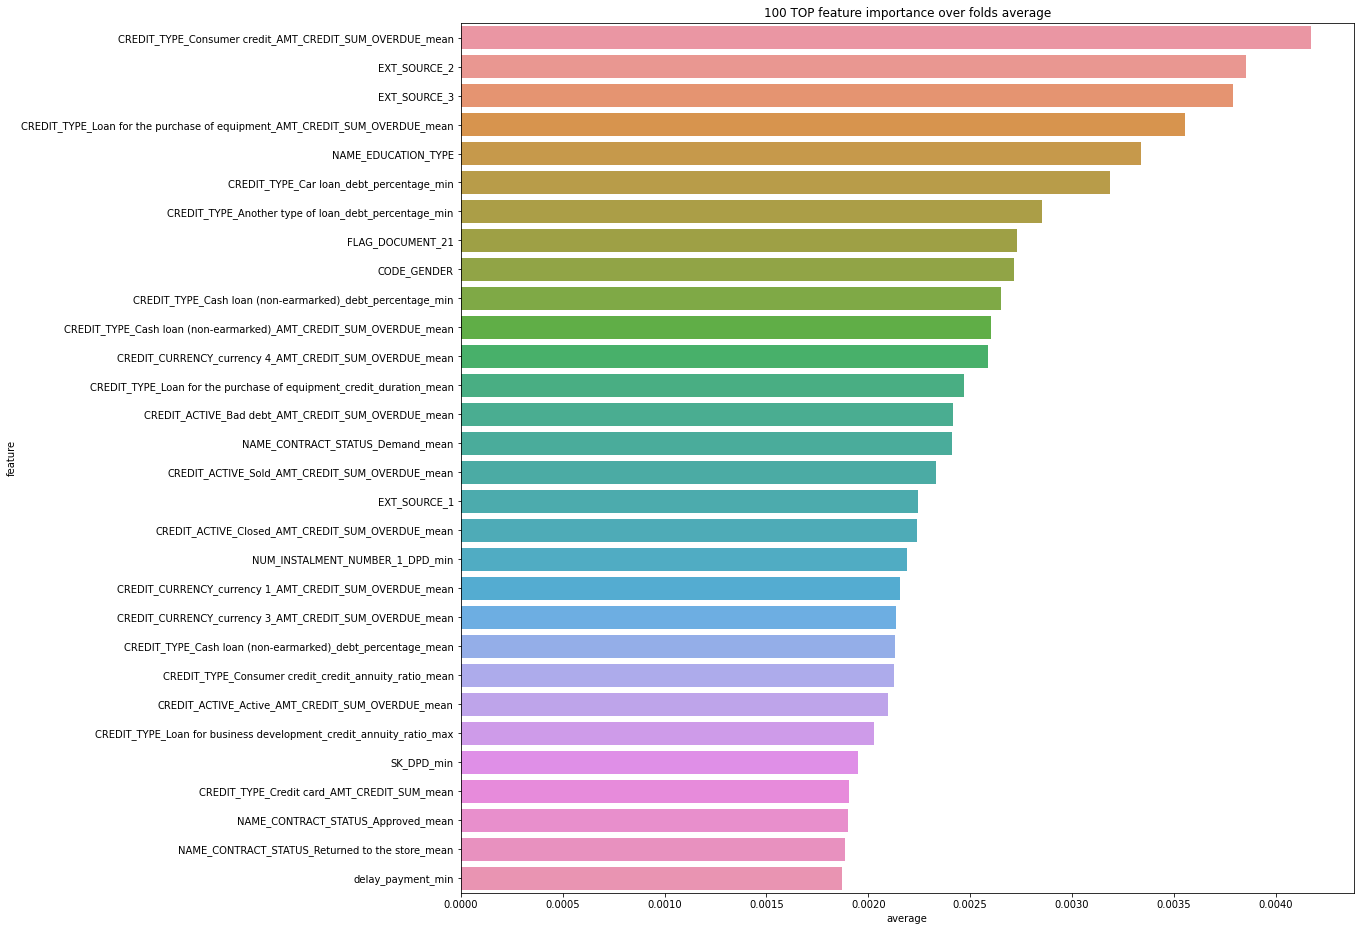

In [ ]:
# feature_importances.to_csv('feature_importances.csv')
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(NFOLDS)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(30), x='average', y='feature');
plt.title('100 TOP feature importance over folds average');





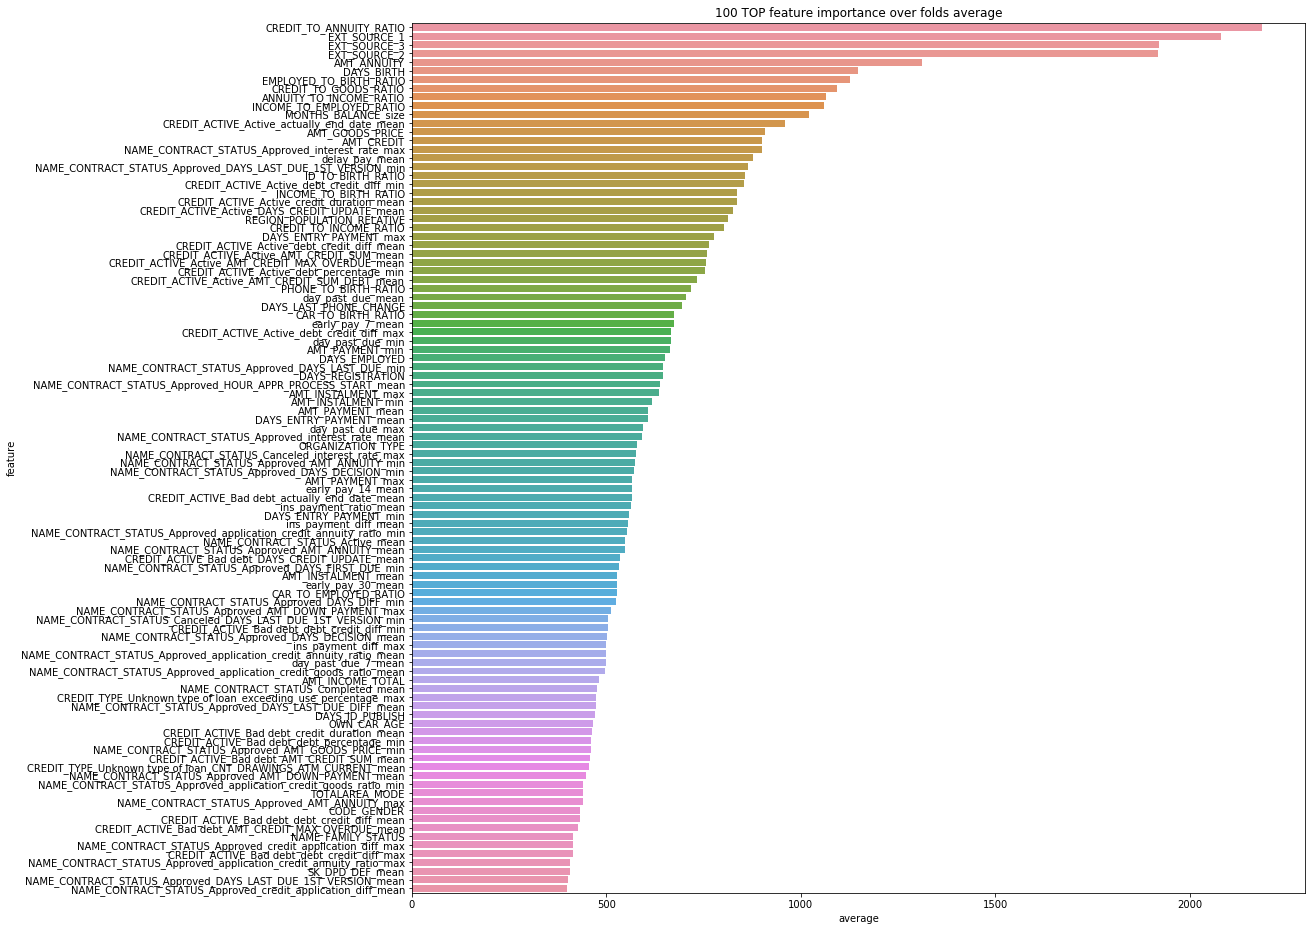

In [ ]:
# feature_importances.to_csv('feature_importances.csv')
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(NFOLDS)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(100), x='average', y='feature');
plt.title('100 TOP feature importance over folds average');




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0653a81d0>]],
      dtype=object)

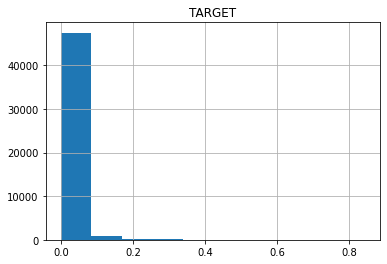

In [ ]:
submission = pd.read_csv('/content/drive/My Drive/home_credit/sample_submission.csv')
submission['TARGET'] = predictions

submission.hist('TARGET')


In [ ]:
submission.to_csv('/content/drive/My Drive/home_credit/sample_submission_xgb1.csv', index=False)

In [ ]:
!pip install shap

     |████████████████████████████████| 273 kB 1.2 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-macosx_10_15_x86_64.whl size=310347 sha256=0c8109cad97cf97ca1811f67b933361d90d29a78a456bdc67afa02e95faf2448
  Stored in directory: /Users/arvis/Library/Caches/pip/wheels/c3/e0/82/26cebc699e23c6a1b9963981e1a10ed7de75db012f4af12428
Successfully built shap
You should consider upgrading via the '/Users/arvis/.pyenv/versions/3.7.0/envs/crawler3.7/bin/python -m pip install --upgrade pip' command.


In [ ]:
import shap
explainer = shap.TreeExplainer(estimator)



In [ ]:
sample = vl_x.sample(n=20000)

In [ ]:

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(vl_x)

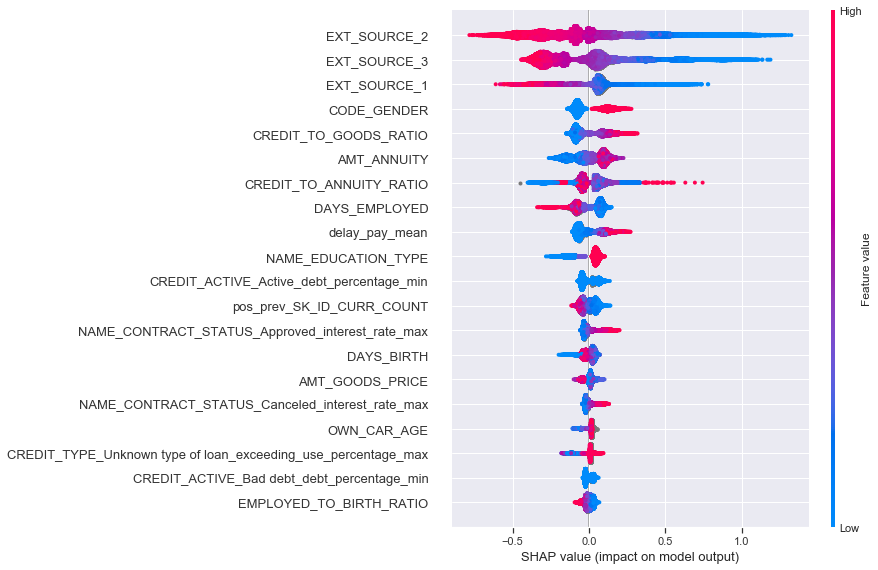

In [ ]:
shap.summary_plot(shap_values[1], vl_x)

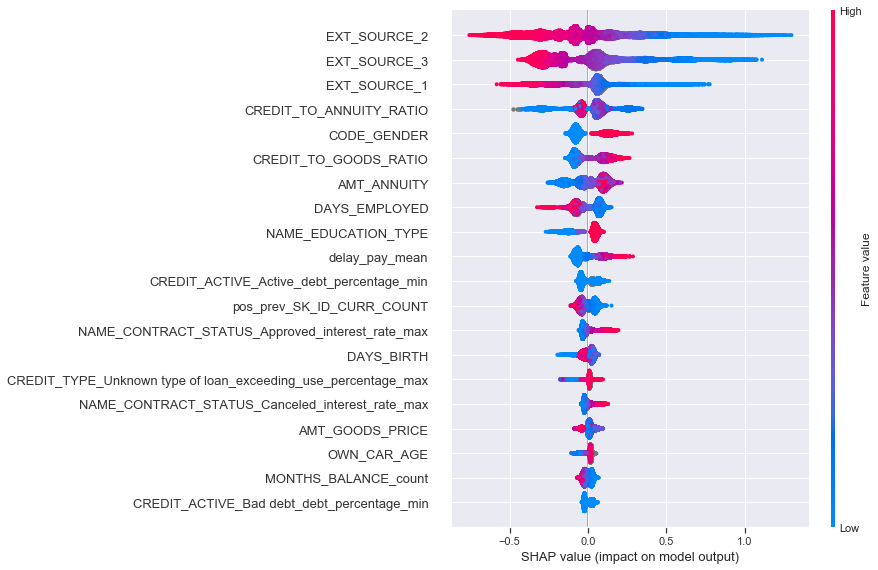

In [ ]:
shap.summary_plot(shap_values[1], test_features)

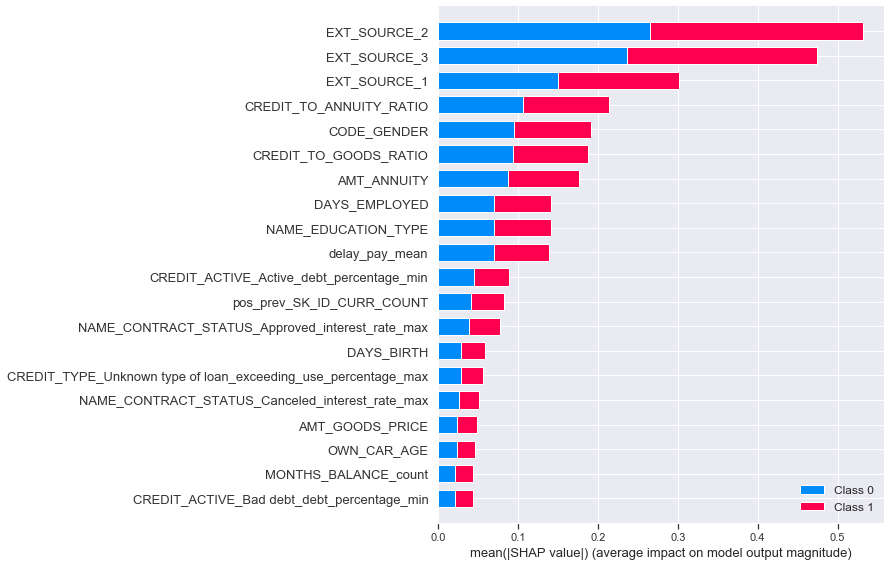

In [ ]:
shap.summary_plot(shap_values, test_features)